This is attempting to improve on my first simple LGBM model with only 3 features.


## Reading Data and Importing Libraries ##

In [1]:
import riiideducation
# import dask.dataframe as dd
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
env = riiideducation.make_env()

In [2]:
train = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/train.csv',
                   usecols=[1, 2, 3, 4, 7, 8, 9],
                   dtype={'timestamp': 'int64',
                          'user_id': 'int32',
                          'content_id': 'int16',
                          'content_type_id': 'int8',
                          'answered_correctly':'int8',
                          'prior_question_elapsed_time': 'float32',
                          'prior_question_had_explanation': 'boolean'}
                   )

Affirmatives (True) for content_type_id are only for those with a different type of content (lectures). These are not real questions.

In [3]:
#removing True or 1 for content_type_id

train = train[train.content_type_id == False]

#arrange by timestamp

train = train.sort_values(['timestamp'], ascending=True).reset_index(drop = True)

train.head(10)

,timestamp,user_id,content_id,content_type_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,115,5692,0,1,NaN,<NA>
1,0,1805962620,5547,0,0,NaN,<NA>
2,0,2015251289,4024,0,1,NaN,<NA>
3,0,867941388,6659,0,1,NaN,<NA>
4,0,867946278,3977,0,1,NaN,<NA>
5,0,867947333,7900,0,1,NaN,<NA>
6,0,1440786713,3889,0,1,NaN,<NA>
7,0,1805972720,5796,0,0,NaN,<NA>
8,0,579725075,7900,0,1,NaN,<NA>
9,0,390617956,4867,0,1,NaN,<NA>


In [4]:
#getting final results ready for later, so we can clear memory
results_c_final = train[['content_id','answered_correctly']].groupby(['content_id']).agg(['mean'])
results_c_final.columns = ["answered_correctly_content"]

results_u_final = train[['user_id','answered_correctly']].groupby(['user_id']).agg(['mean', 'sum', 'count'])
results_u_final.columns = ['answered_correctly_user', 'sum', 'count']

In [5]:
#saving value to fillna
elapsed_mean = train.prior_question_elapsed_time.mean()

## Data Exploration ##

In [6]:
train.loc[(train.timestamp == 0)].answered_correctly.mean()

0.6787809364253148

In [7]:
train.loc[(train.timestamp != 0)].answered_correctly.mean()

0.6571491814363561

In [8]:
train.loc[(train.timestamp < 1000000) & (train.timestamp > 0)].answered_correctly.mean()

0.4760203372564661

Are early questions fundamentally different? The best answer I could get was: not really

In [9]:
train.prior_question_had_explanation.value_counts()

True     89685560
False     9193234
Name: prior_question_had_explanation, dtype: Int64

In [10]:
train.answered_correctly.mean()

0.6572355454194717

In [11]:
train.drop(['timestamp', 'content_type_id'], axis=1, inplace=True)

## Creating Validation Set (Most Recent Answers by User) ##

In [12]:
validation = pd.DataFrame()

In [13]:
for i in range(4):
    last_records = train.drop_duplicates('user_id', keep = 'last')
    train = train[~train.index.isin(last_records.index)]
    validation = validation.append(last_records)

In [14]:
len(train)

97697098

In [15]:
len(validation)

1574202

In [16]:
validation.answered_correctly.mean()

0.5335192052862339

In [17]:
train.answered_correctly.mean()

0.6592289977743249

Does it make sense to use last questions as validation? Why is the rate of correct answers so low?

## Extracting Training Data ##

In [18]:
X = pd.DataFrame()

In [19]:
for i in range(15):
    last_records = train.drop_duplicates('user_id', keep = 'last')
    train = train[~train.index.isin(last_records.index)]
    X = X.append(last_records)

In [20]:
len(X)

5688652

In [21]:
len(train)

92008446

In [22]:
X.answered_correctly.mean()

0.5565163768147533

In [23]:
train.answered_correctly.mean()

0.6655794621289441

## Aggregating and Shaping Data ##

In [24]:
results_c = train[['content_id','answered_correctly']].groupby(['content_id']).agg(['mean'])
results_c.columns = ["answered_correctly_content"]

results_u = train[['user_id','answered_correctly']].groupby(['user_id']).agg(['mean', 'sum', 'count'])
results_u.columns = ["answered_correctly_user", 'sum', 'count']

In [25]:
#clearing memory
del(train)


In [26]:
X = pd.merge(X, results_u, on=['user_id'], how="left")
X = pd.merge(X, results_c_final, on=['content_id'], how="left")

In [27]:
validation = pd.merge(validation, results_u, on=['user_id'], how="left")
validation = pd.merge(validation, results_c_final, on=['content_id'], how="left")

In [28]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()

X.prior_question_had_explanation.fillna(False, inplace = True)
validation.prior_question_had_explanation.fillna(False, inplace = True)

validation["prior_question_had_explanation_enc"] = lb_make.fit_transform(validation["prior_question_had_explanation"])
X["prior_question_had_explanation_enc"] = lb_make.fit_transform(X["prior_question_had_explanation"])
X.head()

,user_id,content_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,answered_correctly_user,sum,count,answered_correctly_content,prior_question_had_explanation_enc
0,888540983,6269,1,NaN,False,NaN,NaN,NaN,0.821711,0
1,1418755930,5314,1,NaN,False,NaN,NaN,NaN,0.783144,0
2,2004252207,128,1,NaN,False,NaN,NaN,NaN,0.966869,0
3,825864574,8440,1,NaN,False,NaN,NaN,NaN,0.953749,0
4,1646232520,4357,1,NaN,False,NaN,NaN,NaN,0.764535,0


In [29]:
#reading in question df
questions_df = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/questions.csv',
                            usecols=[0, 3],
                            dtype={'question_id': 'int16',
                              'part': 'int8'}
                          )

In [30]:
X = pd.merge(X, questions_df, left_on = 'content_id', right_on = 'question_id', how = 'left')
validation = pd.merge(validation, questions_df, left_on = 'content_id', right_on = 'question_id', how = 'left')
X.part = X.part - 1
validation.part = validation.part - 1

X.part.value_counts()

4    2949470
1    1154514
5     519617
3     454899
0     274922
6     178413
2     156817
Name: part, dtype: int64

In [31]:
y = X['answered_correctly']
X = X.drop(['answered_correctly'], axis=1)
X.head()

y_val = validation['answered_correctly']
X_val = validation.drop(['answered_correctly'], axis=1)

In [32]:
X = X[['answered_correctly_user', 'answered_correctly_content', 'sum', 'count',
       'prior_question_elapsed_time','prior_question_had_explanation_enc', 'part']]
X_val = X_val[['answered_correctly_user', 'answered_correctly_content', 'sum', 'count',
       'prior_question_elapsed_time','prior_question_had_explanation_enc', 'part']]

In [33]:

# Filling with 0.5 for simplicity; there could likely be a better value
X['answered_correctly_user'].fillna(0.5,  inplace=True)
X['answered_correctly_content'].fillna(0.5,  inplace=True)

X['part'].fillna(4, inplace = True)
X['sum'].fillna(0, inplace = True)
X['count'].fillna(0, inplace = True)
X['prior_question_elapsed_time'].fillna(elapsed_mean, inplace = True)
X['prior_question_had_explanation_enc'].fillna(0, inplace = True)


In [34]:
# Filling with 0.5 for simplicity; there could likely be a better value
X_val['answered_correctly_user'].fillna(0.5,  inplace=True)
X_val['answered_correctly_content'].fillna(0.5,  inplace=True)

X_val['part'].fillna(4, inplace = True)
X_val['count'].fillna(0, inplace = True)
X_val['sum'].fillna(0, inplace = True)
X_val['prior_question_elapsed_time'].fillna(elapsed_mean, inplace = True)
X_val['prior_question_had_explanation_enc'].fillna(0, inplace = True)

## Modeling ##

In [35]:
import lightgbm as lgb

params = {
    'objective': 'binary',
    'max_bin': 700,
    'learning_rate': 0.0175,
    'num_leaves': 80
}

lgb_train = lgb.Dataset(X, y, categorical_feature = ['part', 'prior_question_had_explanation_enc'])
lgb_eval = lgb.Dataset(X_val, y_val, categorical_feature = ['part', 'prior_question_had_explanation_enc'], reference=lgb_train)

In [36]:
model = lgb.train(
    params, lgb_train,
    valid_sets=[lgb_train, lgb_eval],
    verbose_eval=50,
    num_boost_round=10000,
    early_stopping_rounds=12
)

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 12 rounds
[50]	training's binary_logloss: 0.613885	valid_1's binary_logloss: 0.630455
[100]	training's binary_logloss: 0.597501	valid_1's binary_logloss: 0.617506
[150]	training's binary_logloss: 0.593094	valid_1's binary_logloss: 0.614234
[200]	training's binary_logloss: 0.591459	valid_1's binary_logloss: 0.612883
[250]	training's binary_logloss: 0.590664	valid_1's binary_logloss: 0.612151
[300]	training's binary_logloss: 0.590152	valid_1's binary_logloss: 0.611606
[350]	training's binary_logloss: 0.589803	valid_1's binary_logloss: 0.611247
[400]	training's binary_logloss: 0.58954	valid_1's binary_logloss: 0.61108
[450]	training's binary_logloss: 0.589368	valid_1's binary_logloss: 0.610988
[500]	training's binary_logloss: 0.589226	valid_1's binary_logloss: 0.610898
[550]	training's binary_logloss: 0.589091	valid_1's binary_logloss: 0.610829
[600]	training's binary_logloss: 0.58898	valid_1's binary_logloss: 0.610781
[650]	training's bi

In [37]:
y_pred = model.predict(X_val)
y_true = np.array(y_val)
roc_auc_score(y_true, y_pred)

0.7260482266520388

## Examining Feature Importance ##

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

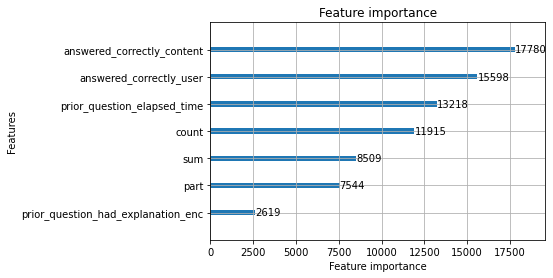

In [39]:
#displaying the most important features
lgb.plot_importance(model)
plt.show()

## Making Predictions for New Data ##

In [40]:
iter_test = env.iter_test()

In [41]:
for (test_df, sample_prediction_df) in iter_test:
    test_df = pd.merge(test_df, questions_df, left_on = 'content_id', right_on = 'question_id', how = 'left')
    test_df = pd.merge(test_df, results_u_final, on=['user_id'],  how="left")
    test_df = pd.merge(test_df, results_c_final, on=['content_id'],  how="left")
    test_df['answered_correctly_user'].fillna(0.5,  inplace=True)
    test_df['answered_correctly_content'].fillna(0.5,  inplace=True)
    test_df['part'] = test_df.part - 1

    test_df['part'].fillna(4, inplace = True)
    test_df['sum'].fillna(0, inplace=True)
    test_df['count'].fillna(0, inplace=True)
    test_df['prior_question_elapsed_time'].fillna(elapsed_mean, inplace = True)
    test_df['prior_question_had_explanation'].fillna(False, inplace=True)
    test_df["prior_question_had_explanation_enc"] = lb_make.fit_transform(test_df["prior_question_had_explanation"])
    test_df['answered_correctly'] =  model.predict(test_df[['answered_correctly_user', 'answered_correctly_content', 'sum', 'count',
                                                                  'prior_question_elapsed_time','prior_question_had_explanation_enc', 'part']])
    env.predict(test_df.loc[test_df['content_type_id'] == 0, ['row_id', 'answered_correctly']])